# Importing Dependencies

In [10]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    mean_absolute_percentage_error,
    confusion_matrix,
    classification_report
)
from xgboost import XGBRegressor

# Importing Data

In [11]:
data = pd.read_csv("processed_twitter_data.csv")
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Feature Engineering

In [12]:
data['Lag_1'] = data['Analytics'].shift(1)
data['Lag_2'] = data['Analytics'].shift(2)
data['Lag_3'] = data['Analytics'].shift(3)

data['Pct_Change'] = data['Analytics'].pct_change().shift(-1)

data['Pct_Change'] = data['Pct_Change'].clip(lower=-0.005, upper=0.005)

data = data.dropna(subset=['Lag_1', 'Lag_2', 'Lag_3', 'Pct_Change'])

# Defining Features, Labels and Test-Train Split

In [13]:
features = data[['Comments', 'Retweets', 'Likes', 'mention_count', 'sentiment_textblob',
                 'sentiment_vader', 'Lag_1', 'Lag_2', 'Lag_3']]
labels = data['Pct_Change']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Using XGBoost Regressor

In [14]:
model = XGBRegressor(random_state=42, n_estimators=200, learning_rate=0.05, max_depth=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [15]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Performance Metrics:")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2) Score: {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Performance Metrics:
Root Mean Square Error (RMSE): 0.005166714953905231
Mean Absolute Error (MAE): 0.004186239353076993
R-squared (R2) Score: -0.09190049640875575
Mean Absolute Percentage Error (MAPE): 318976027418.9455


# Feature Importance

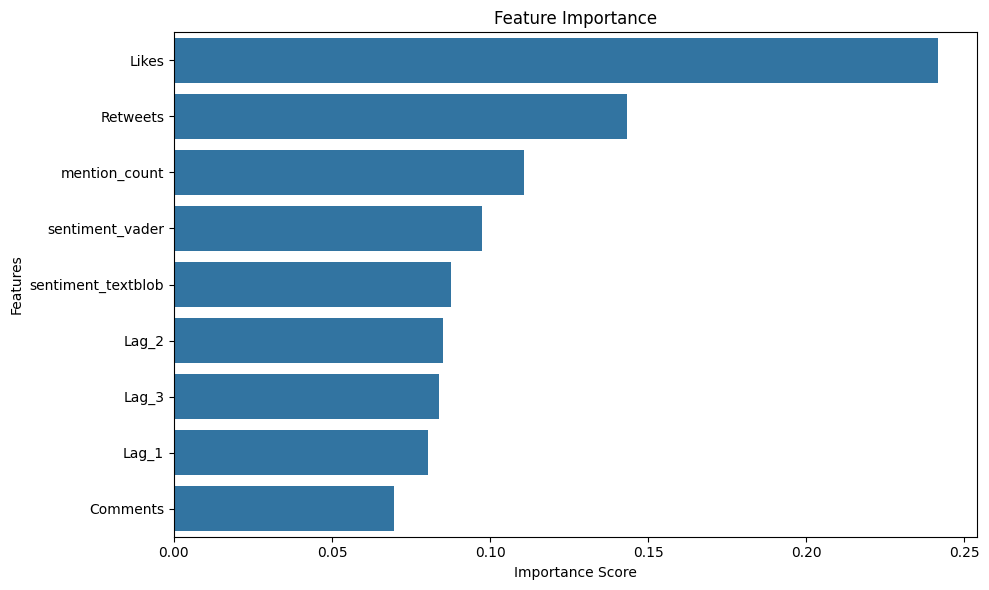

In [16]:
feature_importance = model.feature_importances_
feature_names = features.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Residual Plot

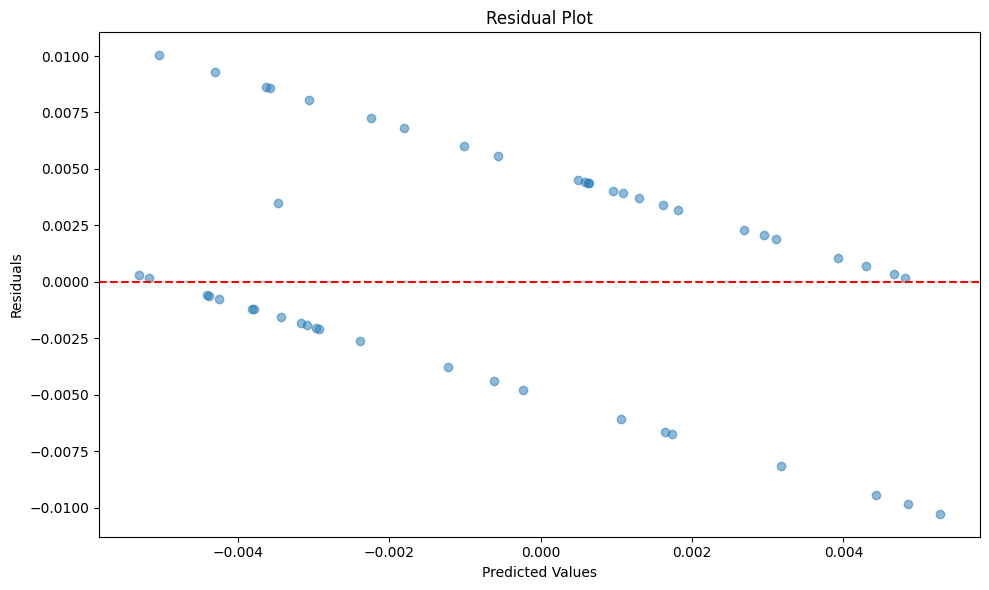

In [17]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# Getting Confusion Matrix

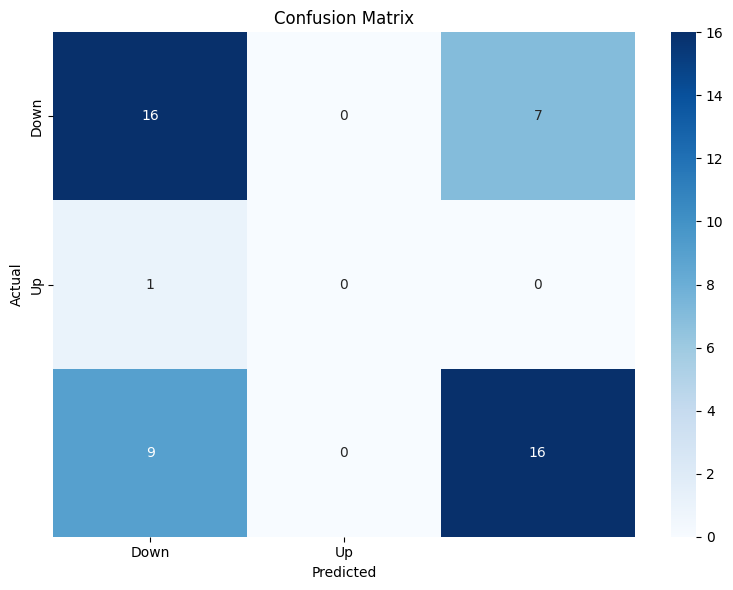

In [19]:
y_test_binary = np.sign(y_test)
y_pred_binary = np.sign(y_pred)

cm = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [20]:
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary))

ticker = "AAPL"  
stock_data = yf.Ticker(ticker)
today_price = stock_data.history(period="1d")['Close'].iloc[0]

latest_data = features.iloc[-1].values.reshape(1, -1)
predicted_pct_change = model.predict(latest_data)[0]

predicted_pct_change = np.clip(predicted_pct_change, -0.005, 0.005)


Classification Report:
              precision    recall  f1-score   support

        -1.0       0.62      0.70      0.65        23
         0.0       0.00      0.00      0.00         1
         1.0       0.70      0.64      0.67        25

    accuracy                           0.65        49
   macro avg       0.44      0.45      0.44        49
weighted avg       0.64      0.65      0.65        49



c:\Users\Rameez Haider\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rameez Haider\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rameez Haider\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

# Approimating Stock Value

In [21]:
print("\nPrediction Results:")
print("Today's Stock Value:", today_price)
predicted_value = today_price * (1 + predicted_pct_change)
print("Predicted Stock Value for the Next Day:", predicted_value)

if today_price > predicted_value:
    print("Stock price goes down")
elif today_price < predicted_value:
    print("Stock price goes up")
else:
    print("No change")


Prediction Results:
Today's Stock Value: 239.2548065185547
Predicted Stock Value for the Next Day: 240.38154636486865
Stock price goes up
